# **Hierarchical Clustering for Banking Client Segmentation**

This notebook implements **Hierarchical Clustering** for **banking clients segmentation**, using **Gower Distance** to handle mixed categorical and numerical features.

## **Pipeline Overview:**
1. **Load & Preprocess Data** (Handling categorical & numerical features)
2. **Compute Gower Distance** (for mixed data types)
3. **Apply Hierarchical Clustering** (Agglomerative approach)
4. **Visualize Clustering with a Dendrogram**
5. **Evaluate Clustering Performance**
6. **Interpret the Clusters** (Understanding the characteristics of each group)


In [2]:
import pandas as pd
import numpy as np

# Load dataset (Update path if necessary)
path = '/Users/mouadh/Fintech_Projects/Business_Case_1/Dataset1_BankClients.xlsx'
data = pd.read_excel(path)

# Drop ID column if present
if 'ID' in data.columns:
    data = data.drop(columns=['ID'])

# Display first 5 rows
data.head()


Age  Gender  Job  Area  CitySize  FamilySize    Income    Wealth      Debt  \
0   24       1    1     2         2           4  0.668046  0.702786  0.262070   
1   47       1    2     2         3           1  0.858453  0.915043  0.730430   
2   38       0    2     1         2           2  0.926818  0.898316  0.441272   
3   67       0    2     1         2           3  0.538797  0.423180  0.600401   
4   33       0    2     1         3           1  0.806659  0.731404  0.831449   

     FinEdu       ESG   Digital  BankFriend  LifeStyle    Luxury    Saving  \
0  0.741853  0.483684  0.698625    0.618259   0.607877  0.897369  0.283222   
1  0.859423  0.537167  0.959025    0.785936   0.862271  0.913729  0.821590   
2  0.485953  0.649434  0.750265    0.699725   0.755404  0.765199  0.503790   
3  0.493144  0.533829  0.590165    0.675353   0.334432  0.517209  0.691240   
4  0.856286  0.784940  0.710026    0.758793   0.908878  0.611610  0.615916   

   Investments  
0            1  
1            3  
2            3  
3            2  
4            2

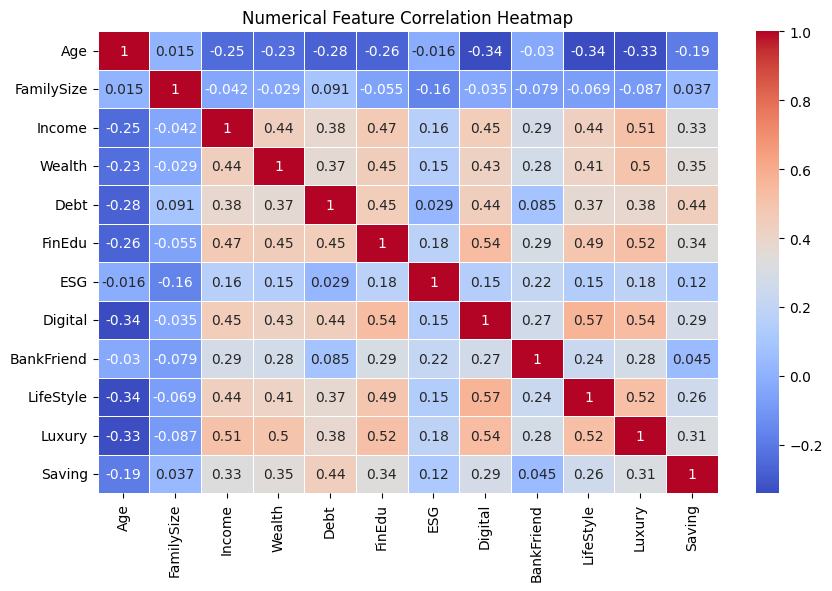

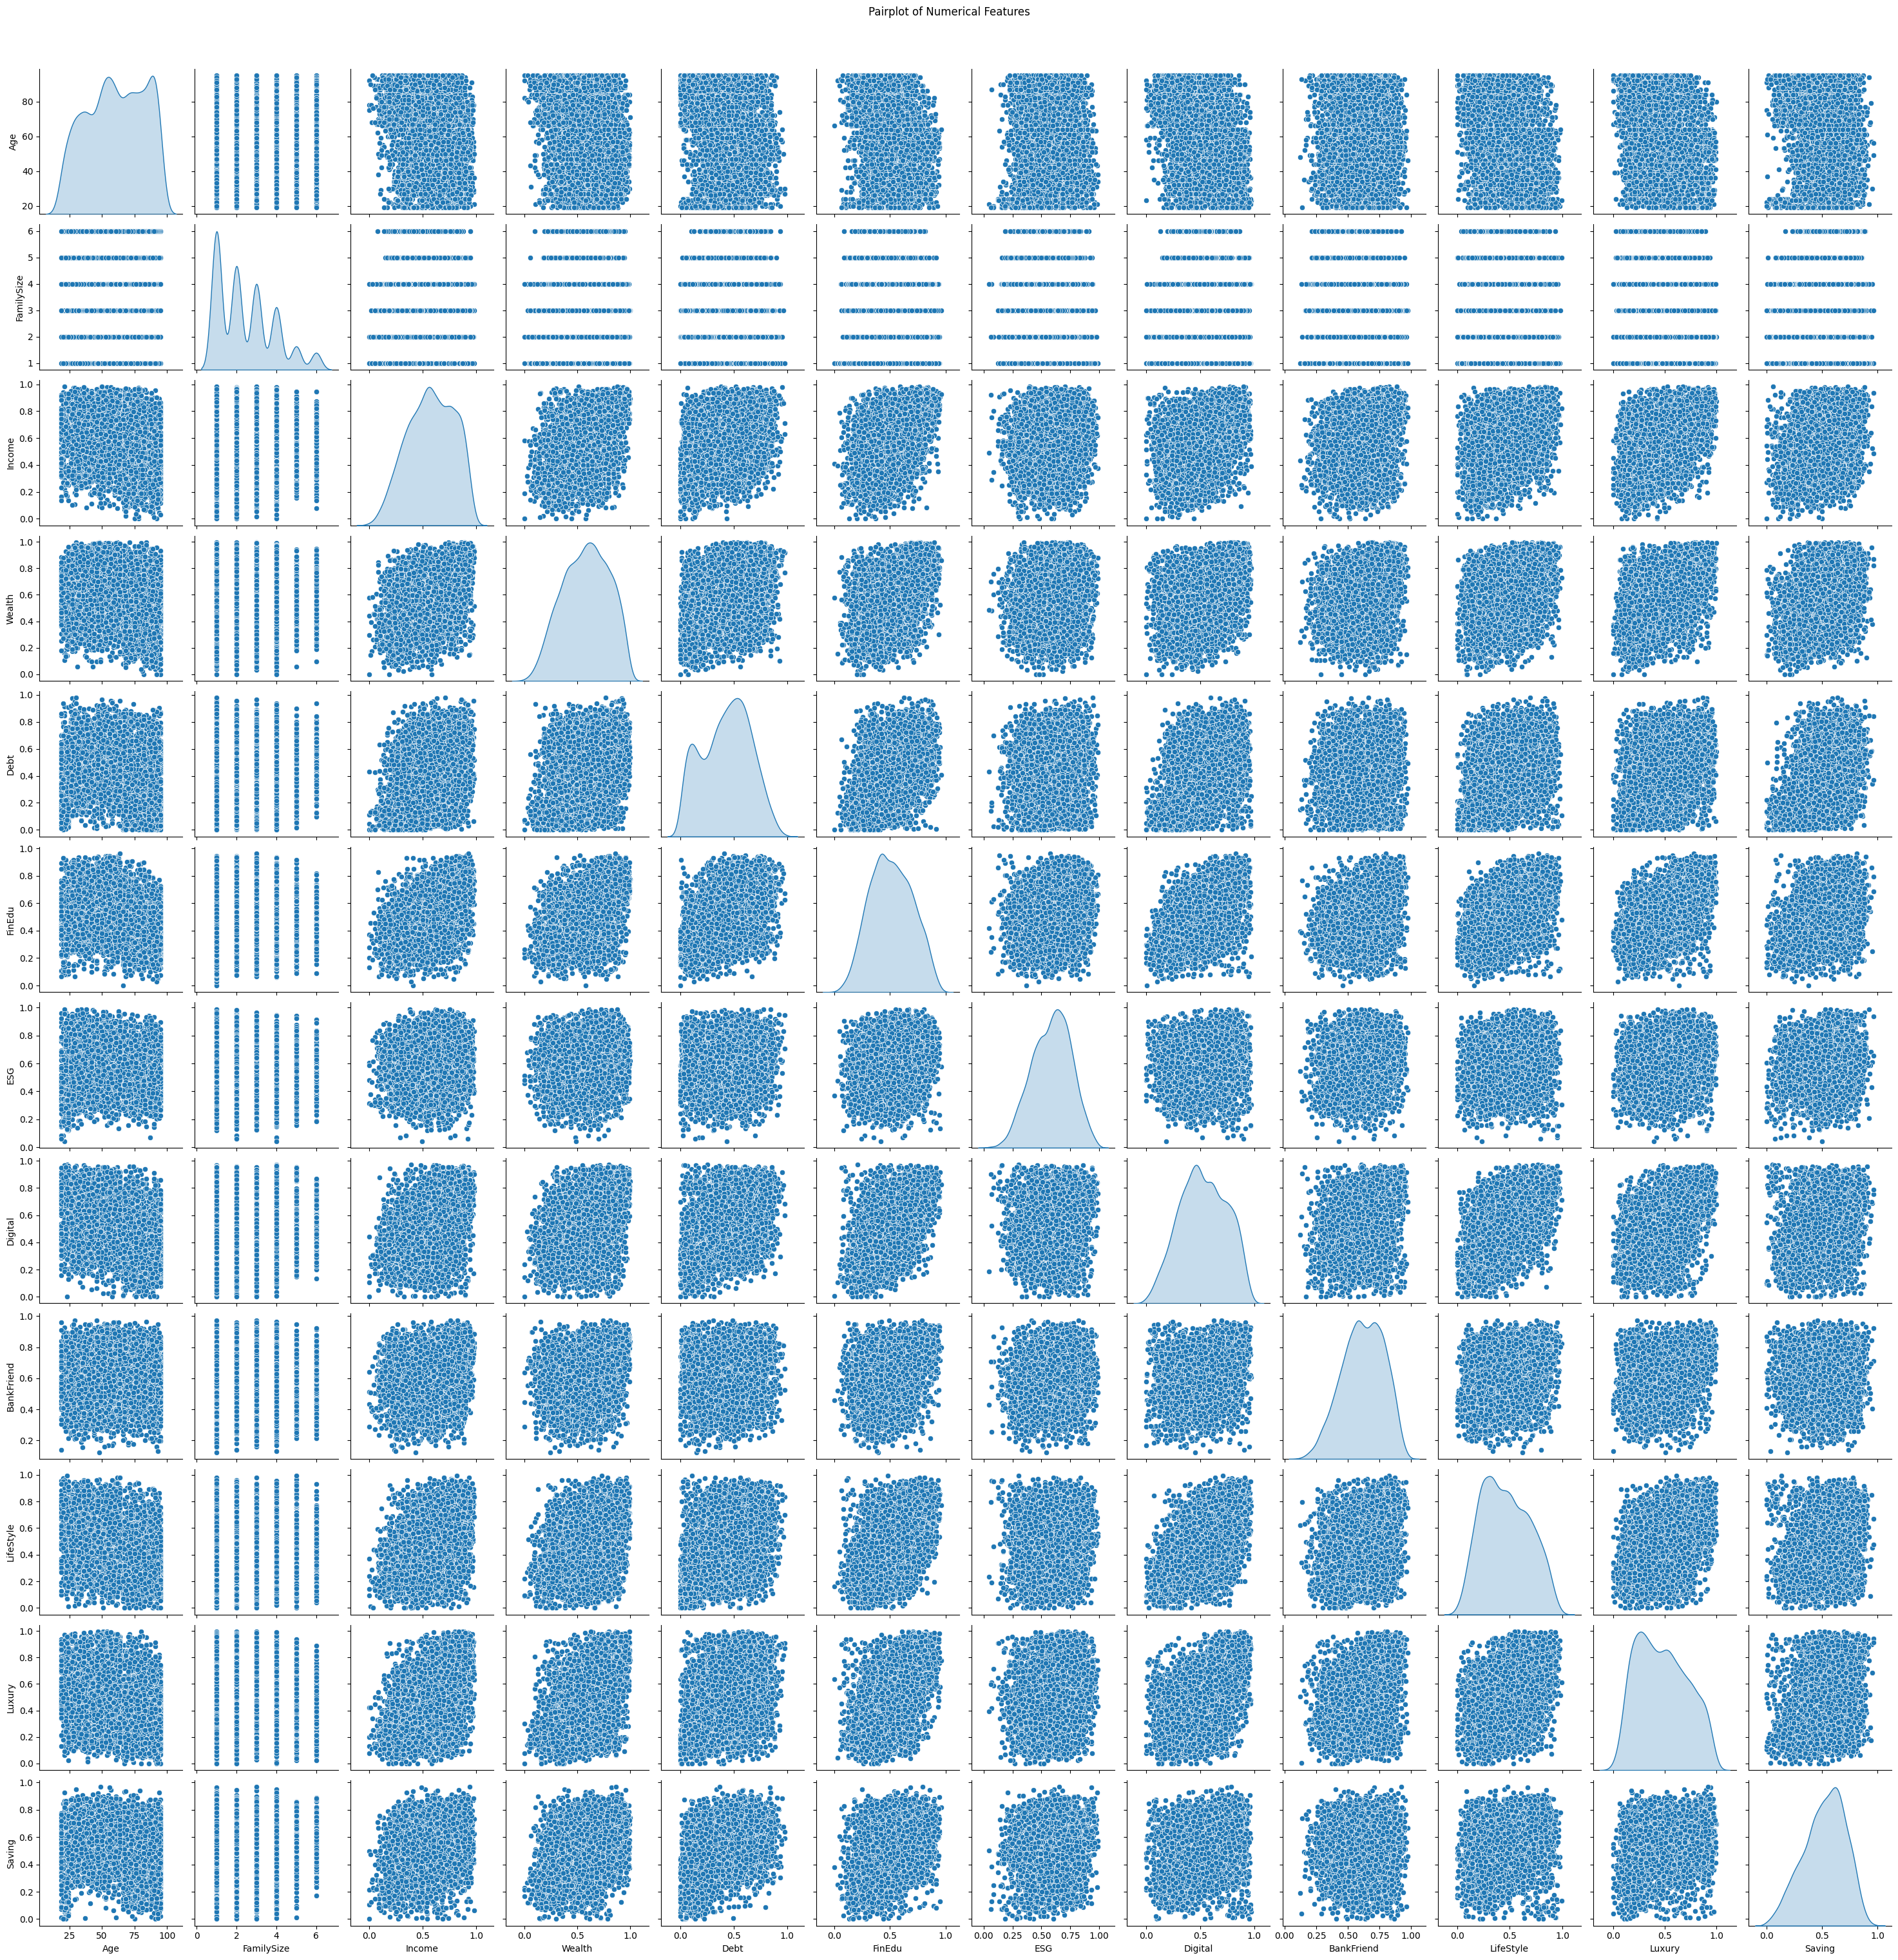

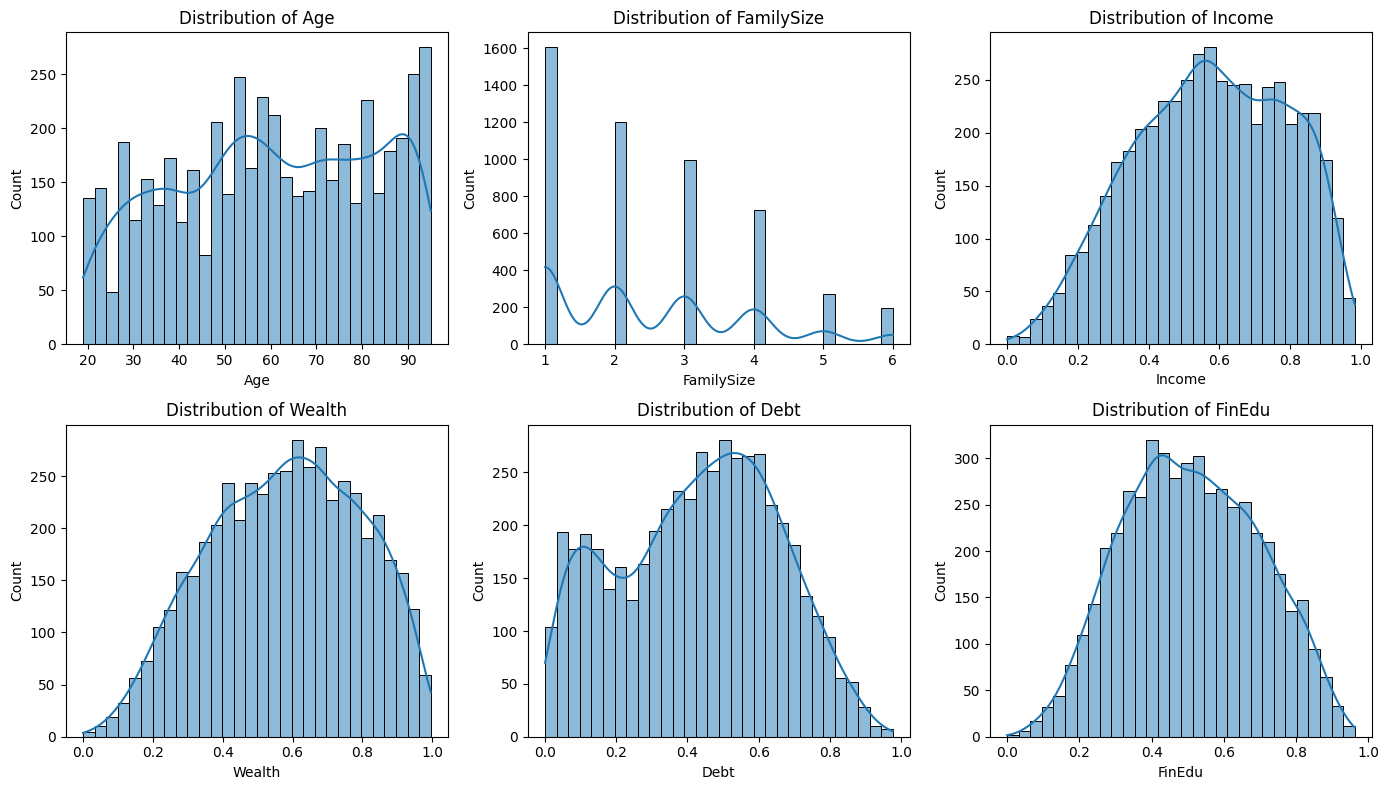

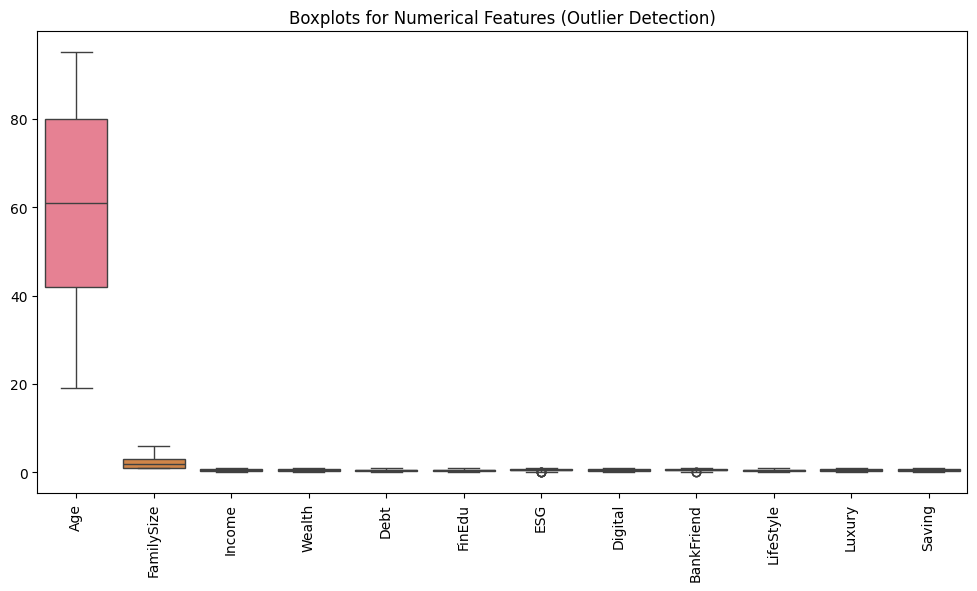

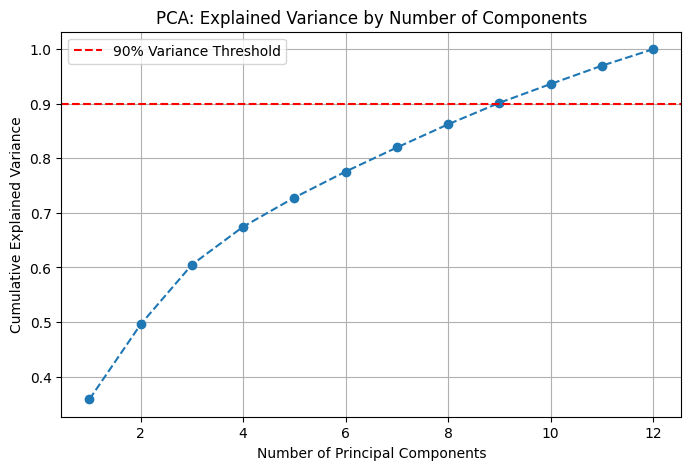

🔹 Highly Correlated Numerical Feature Pairs (Correlation > 0.85):
✅ Adjusted Numerical Features Shape: (5000, 12)
Processed Data Shape After Correlation Filtering: (5000, 28)


In [16]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.decomposition import PCA

# Define categorical columns
categorical_columns = ['Gender', 'Job', 'Area', 'CitySize', 'Investments']

# Separate numerical & categorical features
numerical_features = data.drop(columns=categorical_columns)
categorical_features = data[categorical_columns]

## **🔹 1. Correlation Heatmap**
# Compute correlation matrix for numerical features (Pearson correlation)
corr_matrix = numerical_features.corr(method='pearson')

# Plot heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, cmap='coolwarm', annot=True, linewidths=0.5)
plt.title("Numerical Feature Correlation Heatmap")
plt.show()

## **🔹 2. Pairplot (Scatterplot Matrix)**
sns.pairplot(numerical_features, diag_kind='kde')
plt.suptitle("Pairplot of Numerical Features", y=1.02)
plt.show()

## **🔹 3. Distribution of Features (Histograms & KDE)**
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(14, 8))
axes = axes.flatten()

for i, col in enumerate(numerical_features.columns[:6]):  # Limit to first 6 features
    sns.histplot(numerical_features[col], bins=30, kde=True, ax=axes[i])
    axes[i].set_title(f"Distribution of {col}")

plt.tight_layout()
plt.show()

## **🔹 4. Boxplots for Outlier Detection**
plt.figure(figsize=(12, 6))
sns.boxplot(data=numerical_features)
plt.xticks(rotation=90)
plt.title("Boxplots for Numerical Features (Outlier Detection)")
plt.show()

## **🔹 5. PCA Variance Explained (Dimensionality Reduction Insight)**
scaler = MinMaxScaler()
X_num_scaled = scaler.fit_transform(numerical_features)

pca = PCA()
pca.fit(X_num_scaled)
explained_variance = np.cumsum(pca.explained_variance_ratio_)

# Plot Explained Variance
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(explained_variance)+1), explained_variance, marker='o', linestyle='--')
plt.xlabel("Number of Principal Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("PCA: Explained Variance by Number of Components")
plt.axhline(y=0.90, color='r', linestyle='--', label="90% Variance Threshold")
plt.legend()
plt.grid()
plt.show()

# Identify highly correlated numerical feature pairs (Threshold: 0.85)
high_corr_pairs = set()
for i in range(len(corr_matrix.columns)):
    for j in range(i):
        if abs(corr_matrix.iloc[i, j]) > 0.85:
            high_corr_pairs.add((corr_matrix.columns[i], corr_matrix.columns[j]))

print("🔹 Highly Correlated Numerical Feature Pairs (Correlation > 0.85):")
features_to_drop = []
for pair in high_corr_pairs:
    print(f"⚠️ {pair[0]} ↔ {pair[1]} (Correlation: {corr_matrix.loc[pair[0], pair[1]]:.2f})")
    features_to_drop.append(pair[1])  # Drop the second feature in each pair

# Drop redundant numerical features
numerical_features_reduced = numerical_features.drop(columns=set(features_to_drop))
print(f"✅ Adjusted Numerical Features Shape: {numerical_features_reduced.shape}")

# Scale reduced numerical features
X_num_scaled = scaler.fit_transform(numerical_features_reduced)

# One-hot encode categorical features
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
X_cat_encoded = encoder.fit_transform(categorical_features)

# Concatenate processed numerical & categorical features
X_preprocessed = np.concatenate((X_num_scaled, X_cat_encoded), axis=1)

# Get updated feature names
encoded_feature_names = encoder.get_feature_names_out(categorical_columns)
all_feature_names = numerical_features_reduced.columns.tolist() + encoded_feature_names.tolist()

# Check final shape
print(f'Processed Data Shape After Correlation Filtering: {X_preprocessed.shape}')

In [4]:
import gower

# Compute Gower Distance Matrix
gower_distances = gower.gower_matrix(X_preprocessed)

# Display first 5 rows
gower_distances[:5, :5]


array([[0.        , 0.3308228 , 0.3688255 , 0.3962298 , 0.46500587],
       [0.3308228 , 0.        , 0.28962833, 0.4133628 , 0.27291024],
       [0.3688255 , 0.28962833, 0.        , 0.17167616, 0.21496232],
       [0.3962298 , 0.4133628 , 0.17167616, 0.        , 0.18863821],
       [0.46500587, 0.27291024, 0.21496232, 0.18863821, 0.        ]],
      dtype=float32)

/var/folders/n7/c2d74g5n7vj2bbwp22w33n2h0000gn/T/ipykernel_77838/637393601.py:5: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  Z = linkage(gower_distances, method='ward')  # Alternative methods: 'average', 'complete', 'single'


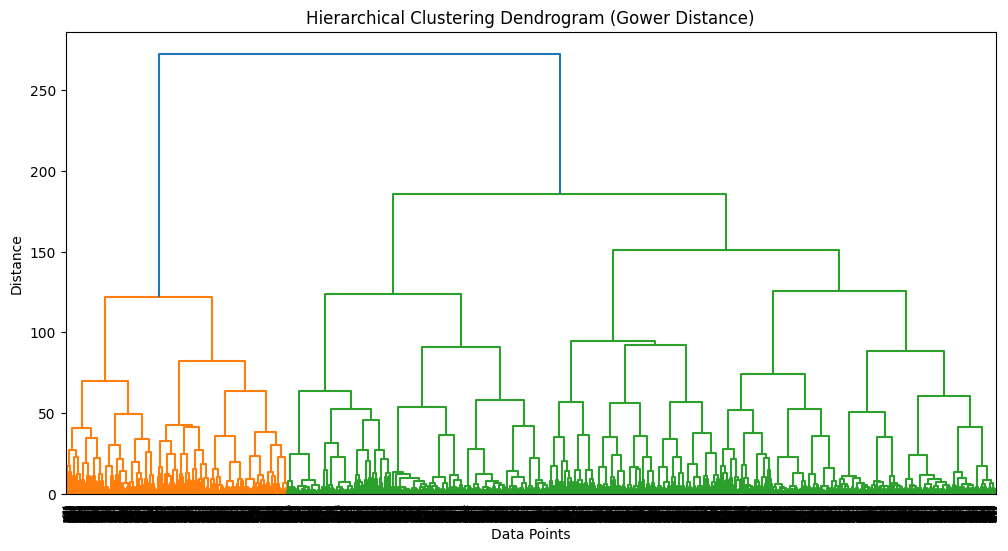

In [5]:
from scipy.cluster.hierarchy import linkage, dendrogram
import matplotlib.pyplot as plt

# Compute linkage matrix
Z = linkage(gower_distances, method='ward')  # Alternative methods: 'average', 'complete', 'single'

# Plot dendrogram
plt.figure(figsize=(12, 6))
dendrogram(Z)
plt.title("Hierarchical Clustering Dendrogram (Gower Distance)")
plt.xlabel("Data Points")
plt.ylabel("Distance")
plt.show()


In [17]:
from scipy.cluster.hierarchy import fcluster

# Define the number of clusters (modify based on dendrogram)
num_clusters = 4

# Extract cluster labels
labels = fcluster(Z, num_clusters, criterion='maxclust')

# Display cluster assignments
print("Cluster Assignments:")
print(labels[:10])  # Print first 10 labels


Cluster Assignments:
[1 4 2 2 2 2 4 1 1 2]


In [18]:
import matplotlib.pyplot as plt
from sklearn.metrics import calinski_harabasz_score, davies_bouldin_score, silhouette_score

# Evaluate clustering
ch_score = calinski_harabasz_score(X_preprocessed, labels)
db_score = davies_bouldin_score(X_preprocessed, labels)
sil_score = silhouette_score(gower_distances, labels, metric='precomputed')

print(f"✅ Calinski-Harabasz Score: {ch_score:.4f}")
print(f"✅ Davies-Bouldin Score: {db_score:.4f}")
print(f"✅ Silhouette Score: {sil_score:.4f}")


✅ Calinski-Harabasz Score: 500.7247
✅ Davies-Bouldin Score: 2.6878
✅ Silhouette Score: 0.1483


In [19]:
# Restore feature names for numerical and categorical variables
encoded_feature_names = encoder.get_feature_names_out(categorical_columns)
all_feature_names = numerical_features.columns.tolist() + encoded_feature_names.tolist()

# Convert back to DataFrame with proper labels
cluster_summary = pd.DataFrame(X_preprocessed, columns=all_feature_names)
cluster_summary['Cluster'] = labels

# Compute mean of each feature per cluster
summary = cluster_summary.groupby('Cluster').mean()

# Reverse MinMax scaling to restore original numerical values
summary_original_scale = summary.copy()
summary_original_scale[numerical_features.columns] = scaler.inverse_transform(summary[numerical_features.columns])

# Convert one-hot encoded categorical values back to original labels
for i, cat_col in enumerate(categorical_columns):
    one_hot_columns = [col for col in summary_original_scale.columns if col.startswith(cat_col + "_")]
    summary_original_scale[cat_col] = summary_original_scale[one_hot_columns].idxmax(axis=1)
    summary_original_scale[cat_col] = summary_original_scale[cat_col].str.split('_').str[1]
    summary_original_scale = summary_original_scale.drop(columns=one_hot_columns)

# Display the DataFrame as a readable table
from IPython.display import display
print("🔹 Cluster Characteristics (Original Scale with Categorical Labels Restored):")
display(summary_original_scale)


🔹 Cluster Characteristics (Original Scale with Categorical Labels Restored):


Age  FamilySize    Income    Wealth      Debt    FinEdu  \
Cluster                                                                  
1        71.612416    2.237416  0.448174  0.451575  0.215974  0.386703   
2        56.173882    2.578424  0.648230  0.656091  0.516044  0.578880   
3        60.532751    2.795852  0.569082  0.569126  0.466190  0.493072   
4        55.490897    2.414700  0.613847  0.615045  0.496112  0.557536   

              ESG   Digital  BankFriend  LifeStyle    Luxury    Saving Gender  \
Cluster                                                                         
1        0.591654  0.387587    0.626406   0.334335  0.330711  0.372304      1   
2        0.585708  0.603142    0.643458   0.530651  0.557941  0.574659      0   
3        0.553710  0.505799    0.587001   0.437278  0.438637  0.556620      1   
4        0.605815  0.581692    0.609805   0.516011  0.534606  0.567937      1   

        Job Area CitySize Investments  
Cluster                                
1         5    1        2           2  
2         2    1        3           3  
3         2    2        2           3  
4         2    1        3           3